In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계분석
import scipy.stats as stats
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%matplotlib inline

In [0]:
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/funda_train.csv')
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')

## 예측 대상
 - **16년 6월부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측**

## 모델링 전략
 - **기존 솔루션**: 1위 솔루션에서는 시계열모델에 초점을 뒀고, 2위 솔루션에서는 RF를 사용했으나 분기별 특성, 추세 등을 고려하지 않았음
 - **목적**: 일반 ML 모델을 통해, 분기별 특성을 고려하여 문제를 풀어나가고자 함
- 3개월 단위로 다운샘플링하여, 이전 1년(4개 분기)의 정보로 다음 3개월 매출을 예측

## 변수 생성 전략
  - **목적**: 최대한 많은 feature를 생성하고, 상점매출액 예측에 어느 feature가 중요한지 알아보고자 함.
- 가게에 대한 정보가 부족하므로, 시간 정보 등으로 가게 정보 추가
- 지역마다 경제 부침의 차이가 있으므로 지역별 정보 추가
- 업종마다 매출 변화의 차이가 있으므로 업종별 정보 추가

## 추가 정보
 - **amount**: 음수는 환불/구매 취소
 - **installment_term**: 60 이상은 포인트 사용 (하지만 amount는 할인 전 금액)

# 분석 전에 데이터 처리
 - Dacon 질의응답 내용을 바탕으로 미리 이상한 데이터 처리

In [0]:
minus = train.groupby(['store_id','card_id']).sum()[train.groupby(['store_id','card_id']).sum()['amount']<-0.5].reset_index()
minus = pd.merge(train, minus[['store_id','card_id']], on =['store_id','card_id'], how='right')
minus = minus.groupby(['store_id', 'card_id', 'transacted_date',
       'transacted_time',
       'amount']).count()[minus.groupby(['store_id', 'card_id', 'transacted_date','transacted_time','amount']).count()['card_company']>=2].reset_index()

In [0]:
pd.merge(train, minus[['store_id','card_id']], on =['store_id','card_id'], how='right')

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,977,2100492,c,2019-01-16,00:35,0,경남 양산시,기타 주점업,8142.857143
1,977,2100492,c,2019-01-16,23:13,0,경남 양산시,기타 주점업,-6857.142857
2,977,2100492,c,2019-01-16,23:13,0,경남 양산시,기타 주점업,-6857.142857
3,1538,3330482,c,2018-11-17,00:03,0,경기 하남시,한식 음식점업,6142.857143
4,1538,3330482,c,2018-11-17,23:57,0,경기 하남시,한식 음식점업,-6714.285714
5,1538,3330482,c,2018-11-17,23:57,0,경기 하남시,한식 음식점업,-6714.285714
6,1842,3973815,c,2018-08-07,02:11,0,NaN,NaN,3428.571429
7,1842,3973815,c,2018-10-07,20:06,0,NaN,NaN,-21428.571429
8,1842,3973815,c,2018-10-07,20:06,0,NaN,NaN,-21428.571429
9,2107,4602413,b,2017-10-12,12:52,0,NaN,NaN,1428.571429


# EDA

## 전체

In [0]:
train.shape, submission.shape

((6556613, 9), (1967, 2))

In [0]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [0]:
submission.head()

,store_id,amount
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0


**데이터 관측 기간**

In [5]:
print('Min date from train set: %s' % train['transacted_date'].min())
print('Max date from train set: %s' % train['transacted_date'].max())

Min date from train set: 2016-06-01
Max date from train set: 2019-02-28


**결측을 살펴보자**
 - region, type_of_business에서만 결측 존재. 주최측에서는 온라인 쇼핑몰일 수도 있지만, 단순 누락일 확률이 더 높다고 한다.
 - 1976개의 store_id에서 각각 약 35%, 60%가 결측이나 섣불리 예측에서 제외할 수는 없다.
 - Imputation은 원래 값을 유추할 수 있는 단서가 부족하므로 불가능할 것으로 보인다.  


In [6]:
# raw data set에서의 결측 비율
train.isna().sum() / train.shape[0]

store_id            0.000000
card_id             0.000000
card_company        0.000000
transacted_date     0.000000
transacted_time     0.000000
installment_term    0.000000
region              0.311558
type_of_business    0.602843
amount              0.000000
dtype: float64

In [10]:
; # store_id로 묶었을 때의 결측 비율
train[['store_id','region','type_of_business']].groupby('store_id').count().isin([0]).sum() / train[['store_id','region','type_of_business']].groupby('store_id').count().shape[0]

region              0.350788
type_of_business    0.597356
dtype: float64

**Unique value를 살펴보자**

- card_id: 중복이 있으므로 단골 여부 같은 파생변수 활용이 가능하다.
- transacted_date : 정확히는 2년 273일
- region : '시/도'와 '구/시'로 구분 가능하다.
- type_of_business : 마지막 단어로 업종 구분이 가능하다(음식점업, 도매업 등)

In [0]:
for col in train.columns:
  print(col,' : ',train[col].nunique())
print('-' * 100)
for col in train.columns:
  print(col,' : ',train[col].unique())

store_id  :  1967
card_id  :  3950001
card_company  :  8
transacted_date  :  1003
transacted_time  :  1440
installment_term  :  34
region  :  180
type_of_business  :  145
amount  :  30551
----------------------------------------------------------------------------------------------------
store_id  :  [   0    1    2 ... 2134 2135 2136]
card_id  :  [      0       1       2 ... 4663854 4663855 4663856]
card_company  :  ['b' 'h' 'c' 'a' 'f' 'e' 'g' 'd']
transacted_date  :  ['2016-06-01' '2016-06-02' '2016-06-03' ... '2019-01-01' '2019-02-05'
 '2017-10-04']
transacted_time  :  ['13:13' '18:12' '18:52' ... '07:48' '07:51' '08:15']
installment_term  :  [ 0  2  3 60  4  5  6 10 12 15  7  8  9 18 24 16 14 11 20 36 13 35 80 17
 19 23 30 22 83 63 93 65 82 72]
region  :  [nan '서울 종로구' '충북 충주시' '부산 동래구' '경기 평택시' '부산 동구' '광주 동구' '경기 파주시' '대구 수성구'
 '경기 용인시' '서울 중구' '경기 안양시' '경기 수원시' '경기 화성시' '서울 송파구' '서울 마포구' '부산 부산진구'
 '서울 용산구' '충남 금산군' '서울 중랑구' '전남 목포시' '경기 안성시' '서울 영등포구' '서울 동작구' '경기 과천시'
 '경북 경주

**amount의 분포를 살펴보자**

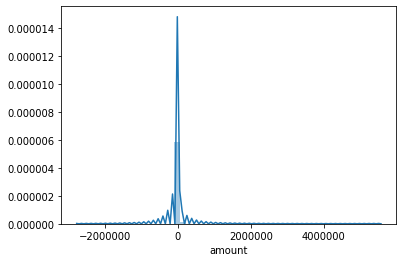

In [0]:
# 개별 결제금액의 분포
sns.distplot(train['amount'])

In [0]:
# 가게별로 3개월로 묶어서 매출액 분포 파악
train2 = train[['store_id','transacted_date','amount']]
train2 = train2.groupby(['store_id','transacted_date']).sum().reset_index()
train2 = train2.pivot(index='transacted_date', columns='store_id', values='amount').reset_index()

train2['transacted_date'] = pd.to_datetime(train2['transacted_date'])
train2 = train2.set_index('transacted_date').resample('3M').sum().iloc[1:] # 6월이 3개월로 묶이지 않아서 제외
train2 = train2.stack()

**3개월 매출액의 분포**

 - skew가 매우 심하므로 log 변환으로 분포를 좁혀준다

In [0]:
train2.reset_index()[train2.reset_index()[0]<0] # 3개월 매출액이 0보다 작은 두 케이스는 일단 제외

,transacted_date,store_id,0
19779,2019-03-31,116,-177142.857143
20453,2019-03-31,838,-617142.857143


Text(0.5, 1.0, '3months log amount sum')

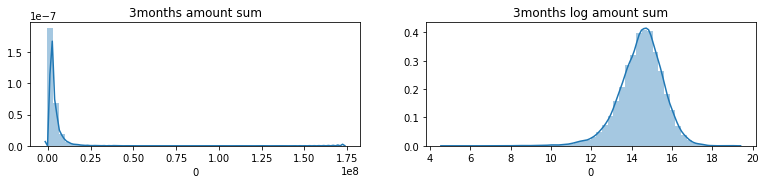

In [0]:
plt.figure(figsize=(13,5))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

sns.distplot(train2.reset_index()[0], ax= ax1)
sns.distplot(np.log(train2.reset_index()[train2.reset_index()[0]>0][0]+1),ax= ax2) # 예측 기간에는 모든 가게에 매출액이 있다고 했으므로 매출액 0은 제외
ax1.set_title('3months amount sum')
ax2.set_title('3months log amount sum')

del train2

**범주형, 연속현 변수 분리**

향후 분석을 위해 3개월 단위로 파생변수 생성을 위해 범주형, 연속형 변수로 df를 나눈다.

In [0]:
train_cat = train[['store_id','transacted_date','card_company','region', 'type_of_business','amount']] # 범주별 결제금액 비교를 위해 amount 추가
train_num = train[['store_id','transacted_date','installment_term','amount']]

## 3개월 단위로 압축

In [0]:
# 3개월 단위의 분기 컬럼 생성 함수
def quarter(data):
  data2 = data.copy()
  data2['quarter'] = np.where((data2.month==12) | (data2.month<=2), 1,                     # 1: 12~1월
                            np.where((data2.month<6) & (data2.month>=3),2,                # 2: 3~5월
                                     np.where((data2.month<9) & (data2.month>=6), 3, 4))) # 3: 6~8월,   4: 9~11월
      
  return data2

In [12]:
!pip install workalendar
from workalendar.asia import SouthKorea # 한국의 공휴일, version : 1.1.1

     |████████████████████████████████| 174kB 4.9MB/s 
     |████████████████████████████████| 16.0MB 304kB/s 
     |████████████████████████████████| 245kB 50.7MB/s 
  Created wheel for pyCalverter: filename=pyCalverter-1.6.1-cp36-none-any.whl size=4200 sha256=109b0c43e777f2f25b264097fc53e2aa6670764323351a7dc24b7705b3164970
  Stored in directory: /root/.cache/pip/wheels/77/4d/86/db4ff4eca6178dbbd5a365d095f97f6021e2a48f09908be79c
  Created wheel for skyfield: filename=skyfield-1.16-cp36-none-any.whl size=273609 sha256=a819fb799b3ac71177de9eb10648ad99a7f8c1144d112535ccc546f0ef6e67f2
  Stored in directory: /root/.cache/pip/wheels/4b/27/4c/29aa7d60909618f39aca67c7170969e2ec6a8c7aebe0c1a455
  Created wheel for jplephem: filename=jplephem-2.12-cp36-none-any.whl size=43929 sha256=4d3aa59e6902daefa95e9ccd93b8e083ec270ac1da13098e408a19df99d7f801
  Stored in directory: /root/.cache/pip/wheels/08/ce/59/bde14a0c20cdfb538a28d78fec79dd628c8d03d5a75f812d1a
  Created wheel for sgp4: filename=sgp4-1.4

In [0]:
# 시간 변수 생성
# https://dacon.io/index.php?mid=code1&category=217514&document_srl=254639
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2016))[:, 0])]).reset_index(drop=True)

times = train[['transacted_date','transacted_time']].drop_duplicates()
times['date2'] = times['transacted_date']
times['time2'] = times['transacted_time']

times['date2'] = pd.to_datetime(times['date2'])
times['year'] = times['date2'].dt.year
#times['year'] = 2019 - times['year'] 
times['month'] = times['date2'].dt.month
times['weekday'] = times['date2'].dt.weekday
times['is_holiday']= times['date2'].dt.date.isin(holidays).astype(int)

times['time2'] = pd.to_datetime(times['time2'])
times['hour'] = times['time2'].dt.hour

del times['date2']
del times['time2']

train = pd.merge(train,times, on=['transacted_date','transacted_time'])

In [0]:
#train.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/funda_train_prep.csv', index=False)
#train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/funda_train_prep.csv')

## 다운샘플링 전에 일부 변수 생성

### 4. installment_term
- is_point: 할부 60개월 이상은 포인트 사용한 경우이므로 1, 아니면 0
 - 60개월 이상은 -60하여 정상적인 할부기간으로 변경
- 포인트 사용은 고정 고객 판단에 대한 지표가 될 수 있음

### 5. amount

파생변수
- refund: 환불/취소 여부

In [0]:
train['is_point'] = np.where(train['installment_term']>=60, 1, 0)
train['installment_term'] = np.where(train['installment_term']>=60, train['installment_term'] - 60, train['installment_term'])
train['refund'] = np.where(train['amount']<0, 1, 0) # 음수면 환불/취소

## 3개월 단위 다운샘플링
- 분기당 3개월의 매출이 모두 있는 경우만 모델 훈련에 사용

In [18]:
train2 = quarter(train)
train2['year'] = np.where(train2['month']==12, train2['year']+1, train2['year'])
quarter_check = train2.groupby(['store_id','year','quarter','month']).count().reset_index()
quarter_check = quarter_check.groupby(['store_id','year','quarter']).count()[['month']].reset_index()
quarter_check

,store_id,year,quarter,month
0,0,2016,3,3
1,0,2016,4,3
2,0,2017,1,3
3,0,2017,2,3
4,0,2017,3,3
...,...,...,...,...
20448,2136,2018,1,3
20449,2136,2018,2,3
20450,2136,2018,3,3
20451,2136,2018,4,3


In [19]:
# 분기 중 실제 값이3개월 미만인 경우 제거
train2 = quarter(train)
train2['year'] = np.where(train2['month']==12, train2['year']+1, train2['year'])
quarter_check = train2.groupby(['store_id','year','quarter','month']).count().reset_index()
quarter_check = quarter_check.groupby(['store_id','year','quarter']).count()[['month']].reset_index()
print('매출액 있는 개월 수/3개월')
print('(3/3) 분기 개수, store_id 개수 : {}, {}'.format(quarter_check[quarter_check['month']==3].shape[0],quarter_check[quarter_check['month']==3].store_id.nunique()))
print('(2/3) 분기 개수, store_id 개수 : {}, {}'.format(quarter_check[quarter_check['month']==2].shape[0],quarter_check[quarter_check['month']==2].store_id.nunique()))
print('(1/3) 분기 개수, store_id 개수 : {}, {}'.format(quarter_check[quarter_check['month']==1].shape[0],quarter_check[quarter_check['month']==1].store_id.nunique()))

quarter_check = quarter_check[quarter_check['month']==3][['store_id','year','quarter']]
train2 = pd.merge(train2, quarter_check, on=['store_id','year','quarter'], how='right').reset_index()

매출액 있는 개월 수/3개월
(3/3) 분기 개수, store_id 개수 : 19661, 1967
(2/3) 분기 개수, store_id 개수 : 457, 358
(1/3) 분기 개수, store_id 개수 : 335, 306


In [0]:
# 3개월 다운샘플링
train2 = train2.groupby(['store_id','year','quarter']).sum()
train2 = train2.drop(['card_id','month','weekday','hour'],axis=1).reset_index()

In [0]:
train2.shape

(19661, 9)

## 1. region
- 띄어쓰기 기준으로 행정구역을 나눠 파생변수 생성.
- 도시별로 구매력 trend를 나타내는 파생변수 생성

In [0]:
# region 변수 나누기
region = train[['store_id','region']].drop_duplicates()
region['region2']= region['region'].str.partition(' ')[0]
region['region3']= region['region'].str.partition(' ')[2]

In [0]:
region.head()

,store_id,region,region2,region3
0,0,NaN,NaN,NaN
1,117,경기 시흥시,경기,시흥시
2,363,인천 서구,인천,서구
3,524,서울 중랑구,서울,중랑구
4,706,대전 중구,대전,중구


In [0]:
train2 = pd.merge(train2, region, on='store_id')

**분기별, 지역의 구매력 trend**

In [0]:
# region3는 가게 수가 적은 지역이 많으므로, 대표성을 위해 region2로 분석
region_trend = train[['region','year','month','amount','store_id']]
region_trend = pd.merge(region_trend, region.drop('store_id',axis=1).drop_duplicates(), on='region').drop('region',axis=1).dropna(axis=0)
region_trend = quarter(region_trend)
region_trend['year'] = np.where(region_trend['month']==12, region_trend['year']+1, region_trend['year'])

세종(4)를 제외하고 31 이상의 가게를 갖고 있으므로 대표성 확보 가능

In [0]:
region_trend[['region2','store_id']].drop_duplicates().groupby('region2').count()['store_id']

region2
강원     44
경기    303
경남     95
경북     71
광주     41
대구     63
대전     36
부산    101
서울    189
세종      4
울산     37
인천     64
전남     39
전북     42
제주     31
충남     57
충북     60
Name: store_id, dtype: int64

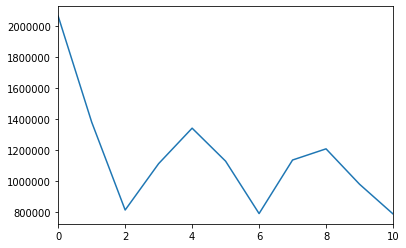

In [0]:
region_trend[(region_trend['region2']=='경기')& (region_trend['store_id']==1914)].groupby(['region2','year','quarter']).sum().reset_index().sort_values(by=['year','quarter'], ascending=[False, True]).reset_index()['amount'].plot()

In [0]:
region_trend2 = region_trend.groupby(['region2','year','quarter']).sum().reset_index().sort_values(by=['year','quarter'], ascending=[False, True]) # 분기별 지역 매출 총합
region_trend2['num_count'] = region_trend.groupby(['region2','year','quarter']).count().reset_index().sort_values(by=['year','quarter'], ascending=[False, True])['store_id'] # 결제빈도

region_trend2['amt_per_region2'] = region_trend2['amount'] / region_trend2['num_count'] # 지역 구매력

region_trend2 = region_trend2.drop(['month','store_id','num_count'],axis=1)
region_trend2.columns = ['region2','year','quarter','region2_amt','amt_per_region2']

지역 정보가 없는 가게를 위해 전국 단위 경제 trend 변수 생성

In [0]:
region_trend3 = region_trend.groupby(['year','quarter']).sum().reset_index()# 분기별 매출 총합
region_trend3['num_count'] = region_trend.groupby(['year','quarter']).count().reset_index()['store_id'] # 결제빈도

region_trend3['amt_per_quarter'] = region_trend3['amount'] / region_trend3['num_count'] # 전국 구매력

region_trend3 = region_trend3.drop(['month','store_id','num_count'],axis=1)
region_trend3.columns = ['year','quarter','quarter_amt','amt_per_quarter']

In [0]:
region_trend2 = pd.merge(region_trend2, region_trend3, on=['year','quarter'])
del region_trend3

In [0]:
region_trend2.head()

,region2,year,quarter,region2_amt,amt_per_region2,quarter_amt,amt_per_quarter
0,강원,2019,1,1.691020e+08,12379.356442,4.421417e+09,11482.55922
1,경기,2019,1,1.009726e+09,11672.323246,4.421417e+09,11482.55922
2,경남,2019,1,2.810193e+08,8021.787916,4.421417e+09,11482.55922
3,경북,2019,1,2.265052e+08,10476.168209,4.421417e+09,11482.55922
4,광주,2019,1,1.240087e+08,15082.545627,4.421417e+09,11482.55922


In [0]:
train2 = pd.merge(train2, region_trend2, on=['year','quarter','region2'], how='outer')

In [0]:
train2.shape

(19661, 16)

## 5. amount

파생변수
- 최소 결제금액(최소 판매단가)
- 평균 결제금액

건당 결제금액의 변화가 시간에 따라 발생할까?

In [0]:
amount = train[['year','month','store_id','amount']]
amount = quarter(amount)
amount['year'] = np.where(amount['month']==12, amount['year']+1, amount['year'])
# 가게별 건당 결제금액 평균
amount_mean =  amount.groupby(['year','quarter','store_id']).mean().reset_index().drop('month', axis=1)
amount_mean.columns = ['year','quarter','store_id','mean_purchase']
# 가게별 건당 결제금액 최솟값(최소 단위)
amount_min =  amount[amount.amount>=0].groupby(['year','quarter','store_id']).min().reset_index().drop('month', axis=1)
amount_min.columns = ['year','quarter','store_id','min_price']

# 병합
amount = amount.drop(['amount','month'],axis=1).drop_duplicates()
amount = pd.merge(amount, amount_mean, on=['year','quarter','store_id'])
amount = pd.merge(amount, amount_min, on=['year','quarter','store_id'])

In [0]:
amount.head(), amount.shape

(   year  store_id  quarter  mean_purchase   min_price
 0  2016         0        3    5310.873337  142.857143
 1  2016       117        3    5800.536273  142.857143
 2  2016       363        3    3904.118404  285.714286
 3  2016       524        3    5529.292073  357.142857
 4  2016       706        3    1226.181423   71.428571, (20453, 5))

In [0]:
train2 = pd.merge(train2, amount, on=['year','quarter','store_id'], how='left')
train2.shape

(19661, 18)

## 2. type_of_business
- region과 같이 파생변수 생성

In [0]:
type_of_business = train[['store_id','type_of_business']].drop_duplicates().dropna()
a = type_of_business['type_of_business'].str.split(' ')
values3 = []
for i in range(a.shape[0]):
  values3.append(a.iloc[i][-1])

type_of_business['type_of_business3'] =values3
type_of_business['type_of_business3'] = np.where((type_of_business['type_of_business3'].str.slice(start=-2)=='학원'),
                                                 '학원', type_of_business['type_of_business3']) # 예외처리
type_of_business['type_of_business3'] = np.where((type_of_business['type_of_business3'].str.slice(start=-3)=='전문점'),
                                                 '음식업점', type_of_business['type_of_business3']) # 예외처리                                                

In [0]:
type_of_business.head(), type_of_business.shape

(    store_id type_of_business type_of_business3
 0          0           기타 미용업               미용업
 1        117          한식 음식점업              음식점업
 2        363           두발 미용업               미용업
 10      1597          한식 음식점업              음식점업
 11      2060          일식 음식점업              음식점업, (792, 3))

In [0]:
train2 = pd.merge(train2, type_of_business, on='store_id', how='left')
train2.shape

(19661, 20)

In [0]:
# type_of_business3로 분석
business_trend = train[['type_of_business','year','month','amount','store_id']]
business_trend = pd.merge(business_trend, type_of_business.drop('store_id',axis=1).drop_duplicates(), on='type_of_business').drop('type_of_business',axis=1).dropna(axis=0)
business_trend = quarter(business_trend)
business_trend['year'] = np.where(business_trend['month']==12, business_trend['year']+1, business_trend['year'])

business_trend2 = business_trend.groupby(['type_of_business3','year','quarter']).sum().reset_index().sort_values(by=['year','quarter'], ascending=[False, True]) # 분기별 지역 매출 총합
business_trend2['num_count'] = business_trend.groupby(['type_of_business3','year','quarter']).count().reset_index().sort_values(by=['year','quarter'], ascending=[False, True])['store_id'] # 결제빈도

business_trend2['amt_per_business3'] = business_trend2['amount'] / business_trend2['num_count'] # 지역 구매력

business_trend2 = business_trend2.drop(['month','store_id','num_count'],axis=1)
business_trend2.columns = ['type_of_business3','year','quarter','business3_amt','amt_per_business3']

In [0]:
train2 = pd.merge(train2, business_trend2, on=['year','quarter','type_of_business3'], how='left')
train2.shape

(19661, 22)

**사업 아이템별 분류**
- 업종과 별개로 사업 아이템 그룹에 따라 매출 추이가 유사하리라는 판단  하에 진행

In [0]:
type_of_business.type_of_business3.unique()

array(['미용업', '도매업', '음식점업', '운영업', '음식업점', '소매업', '주점업', '학원', '세탁업',
       '교육기관', '서비스업', '여행사업', '재배업', '복제업', '판매업', '음료점업', '수리업', '촬영업',
       '마사지업', '세차업', '컨설팅업', '임대업', '슈퍼마켓', '제조업', '한의원', '이용업', '여관업',
       '제과점업', '병원', '연구개발업', '공사업', '의원', '택배업', '편의점', '예식장업'],
      dtype=object)

In [0]:
type_of_business[type_of_business['type_of_business3']=='소매업'].type_of_business.unique()

array(['안경 및 렌즈 소매업', '그 외 기타 분류 안된 상품 전문 소매업', '채소, 과실 및 뿌리작물 소매업',
       '통신기기 소매업', '의복 소매업', '섬유, 직물 및 의복액세서리 소매업', '육류 소매업', '전자상거래 소매업',
       '화장품, 비누 및 방향제 소매업', '가전제품 소매업', '속옷 및 잠옷 소매업', '담배 소매업',
       '문구용품 및 회화용품 소매업', '기타 음ㆍ식료품 위주 종합 소매업', '운동 및 경기용품 소매업',
       '자전거 및 기타 운송장비 소매업', '가구 소매업', '애완용 동물 및 관련용품 소매업',
       '그 외 기타 무점포 소매업', '그 외 기타 종합 소매업', '컴퓨터 및 주변장치, 소프트웨어 소매업',
       '음료 소매업', '화초 및 식물 소매업', '주방용품 및 가정용 유리, 요업 제품 소매업',
       '기념품, 관광 민예품 및 장식용품 소매업', '서적, 신문 및 잡지류 소매업', '건강보조식품 소매업',
       '신발 소매업', '가정용 직물제품 소매업', '공구 소매업', '게임용구, 인형 및 장난감 소매업',
       '그 외 기타 분류 안된 가정용품 소매업', '유아용 의류 소매업', '예술품 및 골동품 소매업',
       '시계 및 귀금속 소매업', '기타 식료품 소매업', '의약품 및 의료용품 소매업', '사무용 기기 소매업',
       '한복 소매업', '신선, 냉동 및 기타 수산물 소매업', '페인트, 창호 및 기타 건설자재 소매업'],
      dtype=object)

## 3. transacted_date,	transacted_time
- 연,월,요일,공휴일,시간 생성
- 계절성 지표 
- 오픈 시간, 주말 오픈 여부
- 매출이 평일/주말 언제 높은지
- 주 매출시간

**오전, 저녁, 야간 영업 유무 파악**
- 24시간을 모두 변수로 만들면 차원이 커지는 반면, 영업시간은 대체로 업종별로 통일된 경우가 많아 정보의 가치는 떨어지므로 4개의 범주로 처리한다. 

In [0]:
working_hour = train.groupby(['store_id','hour']).count()[['amount']].reset_index()

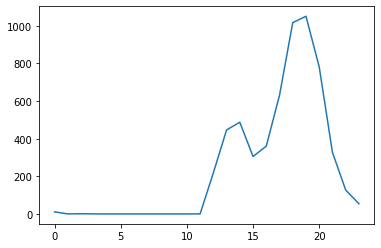

In [0]:
# 영업시간별 결제횟수 그래프 = 영업시간을 파악할 수 있음
i = 4
plt.plot(working_hour[working_hour['store_id']==i]['hour'], working_hour[working_hour['store_id']==i]['amount'])

In [0]:
working_hour['open_time'] = np.where((working_hour['hour']<=7) | (working_hour['hour']==23), 0, # 새벽
                                     np.where((working_hour['hour']>7) & (working_hour['hour']<=12), 1, # 오전
                                               np.where((working_hour['hour']>12) & (working_hour['hour']<=20),2, # 오후,저녁
                                                                                                               3))) # 늦은 저녁(21~23시)
working_hour = pd.get_dummies(working_hour, columns=['open_time']) # 영업시간을 더미변수화
working_hour = working_hour.groupby('store_id').sum().drop(['hour','amount'], axis=1).reset_index() # 영업시간 이외 컬럼 제거

for i in range(4):
  working_hour['open_time_' + str(i)] = np.where(working_hour['open_time_' + str(i)]>=1, 1 ,0) # open_time을 1,0으로 변경                       

In [0]:
working_hour.head()

,store_id,open_time_0,open_time_1,open_time_2,open_time_3
0,0,1,1,1,1
1,1,0,1,1,0
2,2,1,1,1,0
3,4,1,1,1,1
4,5,0,1,1,1


In [0]:
train2 = pd.merge(train2, working_hour, on='store_id')
train2.shape

(19661, 26)

**요일별 결제금액**
- 평일,주말로 나눠서 매출에 차이가 있을까
- 예를 들어, 주매출이 주말인 가게의 다음 분기 매출액의 변동이 적은가?

In [0]:
weekday_amt = train.groupby(['store_id','weekday']).sum()[['amount']].reset_index()
weekday_amt['weekend'] = np.where(weekday_amt['weekday']>=5, 1, 0)
weekday_amt['saturday'] = np.where(weekday_amt['weekday']==5, 1, 0)
weekday_amt['sunday'] = np.where(weekday_amt['weekday']==6, 1, 0)

weekday_amt = weekday_amt.groupby(['store_id','weekend']).mean().reset_index()
weekday_amt['amount_diff'] = np.where(weekday_amt['weekend']==0, weekday_amt['amount']*(-1), weekday_amt['amount']) # 주말, 평일 평균 차이 계산을 위해 평일매출은 음수로 변경 
weekday_amt = pd.get_dummies(weekday_amt, columns=['weekend'],prefix='open').groupby('store_id').sum().reset_index() # 주말, 평일 오픈 여부를 더미변수화
weekday_amt['open_5'] = np.where(weekday_amt['saturday']==0, 0, 1) # 토요일 오픈여부 변수 생성
weekday_amt['open_6'] = np.where(weekday_amt['sunday']==0, 0, 1) # 일요일 오픈여부 변수 생성

weekday_amt['weekend_store'] = np.where(weekday_amt['amount_diff']>0,1,0) # 주말 평균 매출이 더 높은 가게 변수 생성
weekday_amt = weekday_amt[['store_id','weekend_store','open_0','open_5','open_6']]
weekend_store = weekday_amt[weekday_amt['weekend_store']==1]['store_id'] # 주말 평균 매출이 더 높은 가게들 리스트

In [0]:
train2 = pd.merge(train2, weekday_amt, on='store_id')
train2.shape

(19661, 30)

주말에 매출이 높은 가게들의 매출액 평균과 표준편차가 평일 가게의 2분의 1 수준이므로,
의사결정나무에서 유의미한 분기 기준이 될 수 있음 

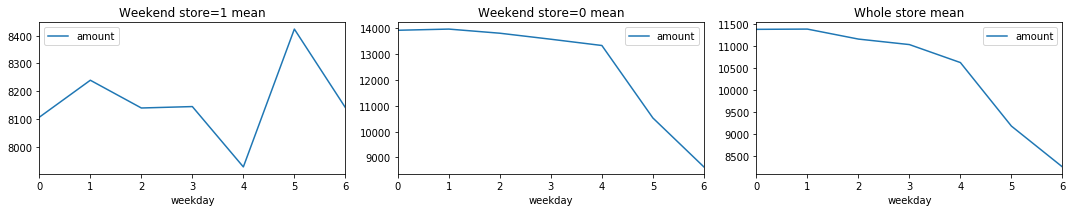

In [0]:
# Weekend store 여부에 따른 매출액 mean 비교
plt.figure(figsize=(15,8))
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)
train.loc[train['store_id'].isin(weekend_store)].groupby(['weekday']).mean()[['amount']].plot(ax=ax1)
train.loc[train['store_id'].isin(weekend_store)==False].groupby(['weekday']).mean()[['amount']].plot(ax=ax2)
train.groupby(['weekday']).mean()[['amount']].plot(ax=ax3)
ax1.set_title('Weekend store=1 mean')
ax2.set_title('Weekend store=0 mean')
ax3.set_title('Whole store mean')
plt.tight_layout()

**계절성 여부** (seasonal_p)
- 분기별로 매출액 표준편차가 차이 존재 --> 특히 3-5월에 낮음
- 분기별 매출액 평균은 p==0이므로 유의미한 차이  --> 특히 3-5월에 낮음
- 따라서 계절성 여부를 나누는 변수는 유의미한 정보가 있음
    - 가게별로 계절성 변수는 p value로 구하는데, 분기 단위 데이터가 적으므로 일단위 매출액으로 계절성 비교할 것임

In [0]:
# 분기별 매출액 비교를 위한 df
seasonal_amt = train[['store_id','month','amount']]
seasonal_amt = quarter(seasonal_amt)
del seasonal_amt['month']

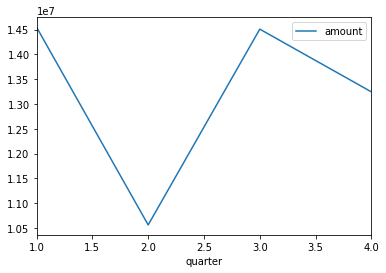

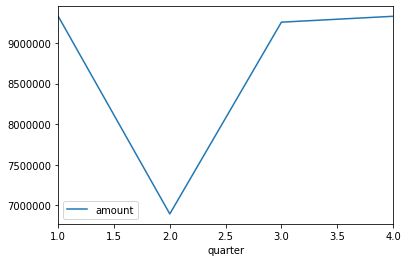

In [0]:
# 분기별 가게들의 매출액
seasonal_amt = seasonal_amt.groupby(['store_id','quarter']).sum()[['amount']].reset_index()
# 분기별 매출액 표준편차,평균 비교 그래프
seasonal_amt.groupby(['quarter']).std()[['amount']].plot()
seasonal_amt.groupby(['quarter']).mean()[['amount']].plot()

In [0]:
# 계절성 p value 구하는 함수
def seasonal_p_value(x):
  import warnings
  warnings.filterwarnings('ignore')
  
  d = {}
  df = pd.DataFrame(x, columns=['quarter', 'amount'])    

  # the "C" indicates categorical data
  model = ols('amount ~ C(quarter)', df).fit()
  d['seasonal_p'] = model.f_pvalue
  return pd.Series(d, index=['seasonal_p'])

In [0]:
seasonal_p = train[['store_id','transacted_date','month','year','amount']]
seasonal_p['transacted_date'] = pd.to_datetime(seasonal_p['transacted_date'])
seasonal_p['day'] = seasonal_p['transacted_date'].dt.day
seasonal_p = seasonal_p.groupby(['store_id','year','month','day']).sum().reset_index() # amount를 일단위로 다운샘플링
seasonal_p = quarter(seasonal_p).drop(['year','month','day'],axis=1)

seasonal_p = seasonal_p.groupby('store_id').apply(seasonal_p_value).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
seasonal_p.head(3)

,store_id,seasonal_p
0,0,0.434025
1,1,0.006937
2,2,0.461739


In [0]:
train2 = pd.merge(train2, seasonal_p, on='store_id')
train2.shape

(19661, 31)

**분기별 영업일수 대비 구매빈도** (action_per_day)
 - 이동환님의 아이디어 참조

In [0]:
store_date_custom = train[['store_id','transacted_date','month','year']]
store_date_custom['transacted_date'] = pd.to_datetime(store_date_custom['transacted_date'])
store_date_custom['day'] = store_date_custom['transacted_date'].dt.day
store_date_custom = store_date_custom.groupby(['store_id','year','month','day']).count().reset_index() # amount를 일단위로 다운샘플링

store_date_custom =quarter(store_date_custom) # 분기 계산
store_date_custom['year'] = np.where(store_date_custom['month']==12, store_date_custom['year']+1, store_date_custom['year']) 

store_date_custom2 = store_date_custom.groupby(['store_id','year','quarter']).sum() # 분기별 결제횟수
store_date_custom2['day_count'] = store_date_custom.groupby(['store_id','year','quarter']).count()['day'] # 분기별 영업일수
store_date_custom2['action_per_day'] = store_date_custom2['transacted_date'] / store_date_custom2['day_count'] # 구매빈도 / 영업일수
store_date_custom2 = store_date_custom2['action_per_day'].reset_index()
del store_date_custom

In [0]:
store_date_custom2.head(2)

,store_id,year,quarter,action_per_day
0,0,2016,3,6.586667
1,0,2016,4,6.202703


In [0]:
train2 = pd.merge(train2, store_date_custom2, on=['year','quarter','store_id'])
train2.shape

(19661, 32)

**주로 매출이 일어나는 시간**
- 업종 컬럼이 결측인 가게들은 주요 매출시간으로 업종 정보 보완이 어느정도 가능.

  ex) 늦은 저녁에 매출이 많은 술집과 일반 식당이 분류됨

In [0]:
main_hour = train[['store_id','hour','amount']]
main_hour = (main_hour.groupby(['store_id','hour']).count() / main_hour.groupby(['store_id']).count()).drop('hour', axis=1).reset_index() # 시간별 결제건수 비율 
main_hour.columns = ['store_id', 'hour', 'main_h_ratio']
main_hour.tail()

,store_id,hour,main_h_ratio
29934,2136,19,0.005907
29935,2136,20,0.032211
29936,2136,21,0.109786
29937,2136,22,0.181008
29938,2136,23,0.206866


['통신기기 소매업']


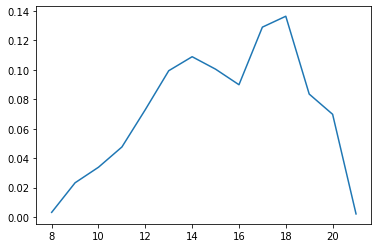

['한식 음식점업']


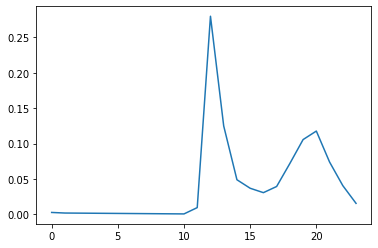

['기타 주점업']


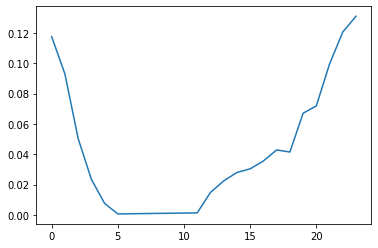

['의복 소매업']


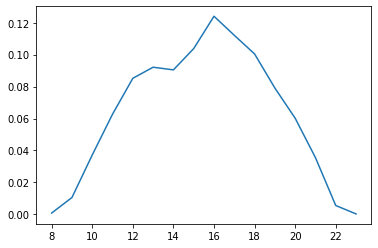

[nan]


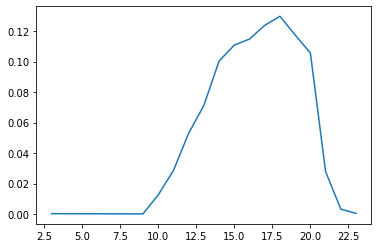

['간이음식 포장 판매 전문점']


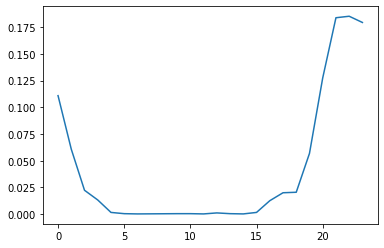

[nan]


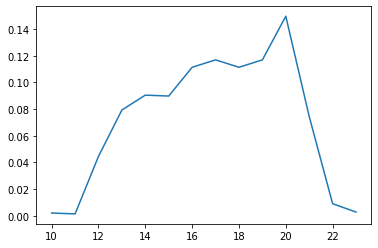

['의복 소매업']


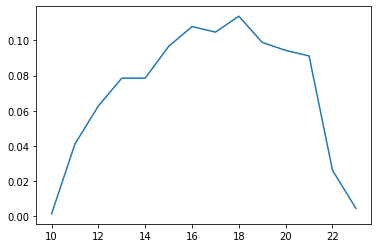

[nan]


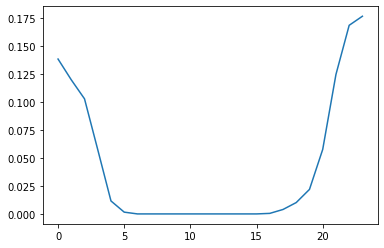

['두발 미용업']


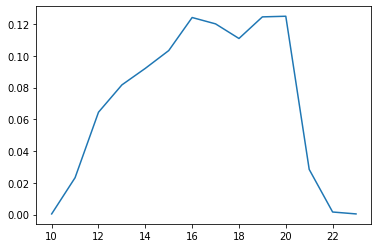

[nan]


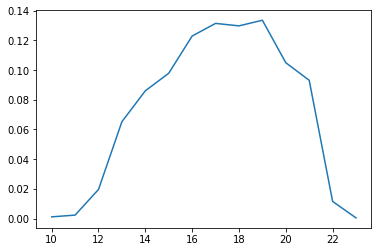

['섬유, 직물 및 의복액세서리 소매업']


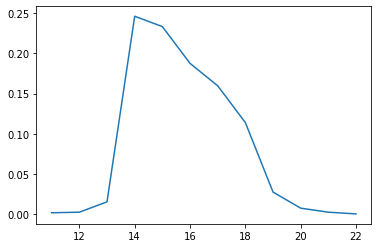

['외국어학원']


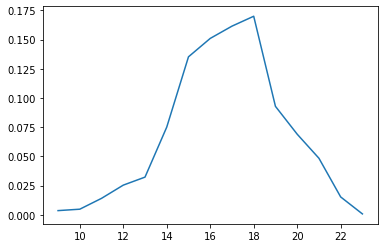

[nan]


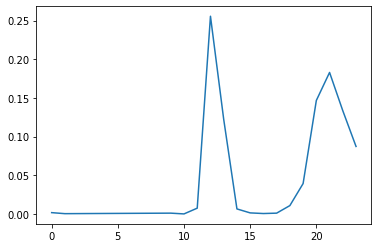

[nan]


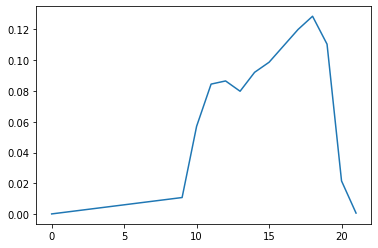

['통신기기 소매업']


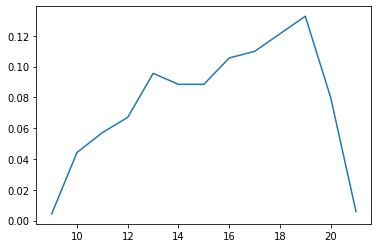

['기타 외국식 음식점업']


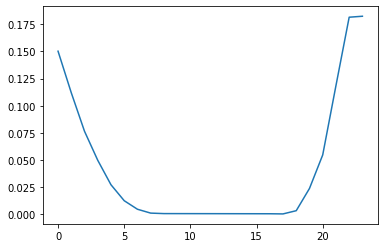

[nan]


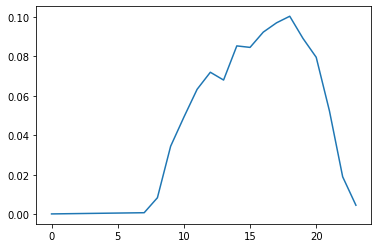

['두발 미용업']


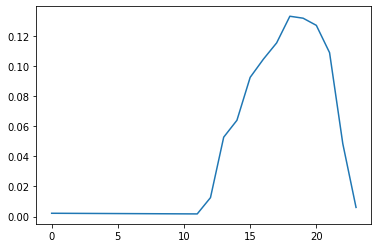

[nan]


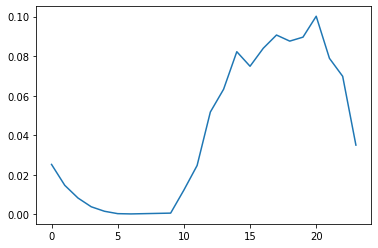

[nan]


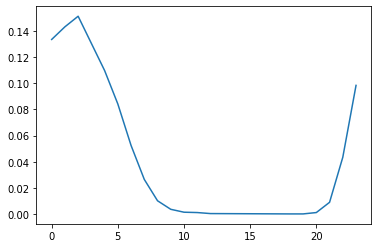

[nan]


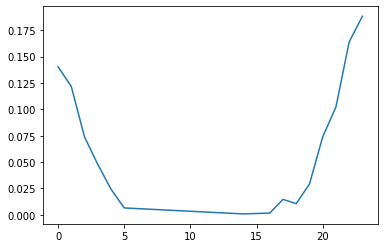

[nan]


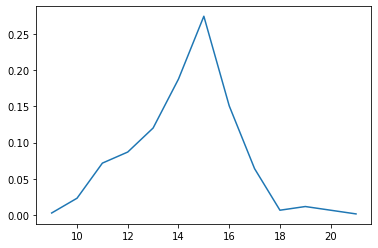

['가정용 세탁업']


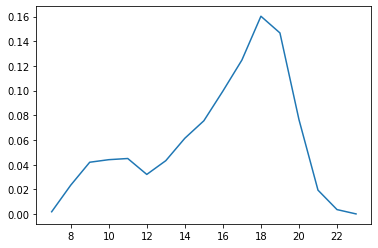

[nan]


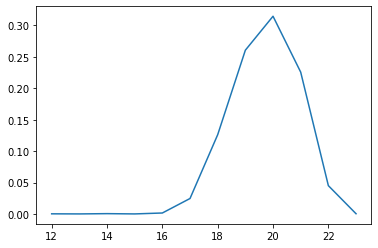

[nan]


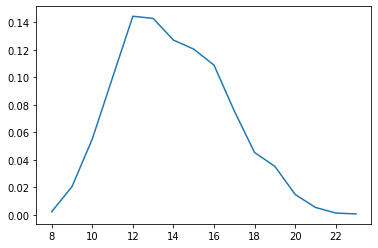

[nan]


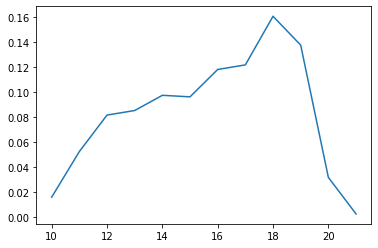

[nan]


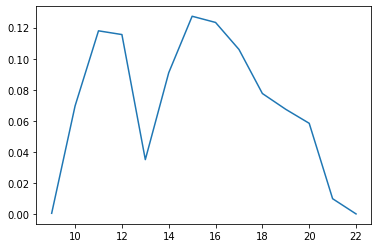

[nan]


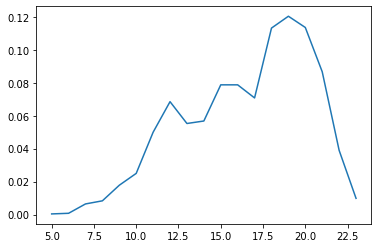

['한식 음식점업']


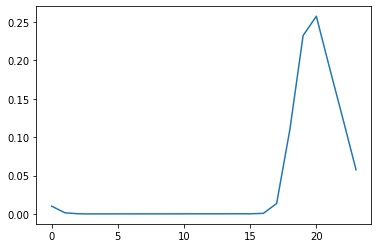

In [0]:
# 샘플 그래프 30개
for i in main_hour.store_id.unique()[30:60]:
  print(train[train['store_id']==i]['type_of_business'].unique())
  plt.plot(main_hour[main_hour['store_id']==i]['hour'],main_hour[main_hour['store_id']==i]['amount'])
  plt.show()

In [0]:
# 더미변수화
main_hour = main_hour.pivot(index='store_id', columns='hour',values='main_h_ratio')
# 컬럼명 재정의
h =[]
for i in range(0,24):
  h.append('main_h_' + str(i))
main_hour.columns = h
# 결측 처리
main_hour = main_hour.fillna(0).reset_index()

In [0]:
main_hour.head()

,store_id,main_h_0,main_h_1,main_h_2,main_h_3,main_h_4,main_h_5,main_h_6,main_h_7,main_h_8,main_h_9,main_h_10,main_h_11,main_h_12,main_h_13,main_h_14,main_h_15,main_h_16,main_h_17,main_h_18,main_h_19,main_h_20,main_h_21,main_h_22,main_h_23
0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000446,0.039500,0.065387,0.083687,0.079893,0.081678,0.097969,0.099085,0.115822,0.124303,0.123410,0.066057,0.020085,0.002232,0.000446
1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.001322,0.020095,0.115283,0.196721,0.203067,0.179270,0.131412,0.083025,0.062930,0.006610,0.000264,0.000000,0.000000,0.000000
2,2,0.000000,0.003425,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.008562,0.003425,0.025685,0.113014,0.159247,0.190068,0.184932,0.142123,0.130137,0.037671,0.000000,0.000000,0.001712
3,4,0.002058,0.000172,0.000343,0.000172,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000172,0.037564,0.076672,0.083705,0.052487,0.061921,0.108233,0.174443,0.180274,0.134134,0.056261,0.021955,0.009434
4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000511,0.004086,0.024004,0.062308,0.102145,0.118488,0.148110,0.149132,0.148110,0.168029,0.065884,0.008172,0.001021,0.000000


In [0]:
train2 = pd.merge(train2, main_hour, on='store_id')

## 6. card_id

- 카드 아이디 = 고객 id

파생변수(3개월 단위)
- num_card_id :  고객 수
- amount_per_card : 고객 수 대비 결제금액
- regular : 단골 고객 수
- regular_amt : 단골 고객의 매출 합계 = 해당 분기 고정매출

In [0]:
card_id = train[['year','month','store_id','card_id','amount']]
card_id = quarter(card_id)
# 1) 전체 고객
card_id2 = quarter(train[['year','month','store_id','card_id','amount']])
card_id2['year'] = np.where(card_id2['month']==12, card_id2['year']+1, card_id2['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)
# 고객 수
num_card_id = card_id2.groupby(['year','quarter','store_id']).count().reset_index().drop(['month','amount'], axis=1)
# 고객 수 대비 결제금액
num_card_id['amount_per_card'] = card_id2.groupby(['year','quarter','store_id']).sum().reset_index().drop(['month','card_id'], axis=1)['amount']
num_card_id['amount_per_card'] = num_card_id['amount_per_card'] / num_card_id['card_id']
num_card_id.columns = ['year', 'quarter', 'store_id', 'num_card_id', 'amount_per_card']

# 2) 단골 고객 = 3개월 평균 3번 이상 결제하는 고객(환불/취소는 제외)
regular_customer = card_id[card_id['amount']>0].groupby(['year','month','store_id','card_id']).count().reset_index() # 월별 방문횟수
regular_customer = quarter(regular_customer)
regular_customer['year'] = np.where(regular_customer['month']==12, regular_customer['year']+1, regular_customer['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)
regular_customer = regular_customer.groupby(['year','quarter','store_id','card_id']).count().reset_index()
regular_customer['regular'] = np.where(regular_customer['month']==3, 1, 0) # 매월 방문한 사람은 단골고객
# 가게마다 분기별로 단골고객 매출(= 고정매출을 의미함)
regular_customer2 = regular_customer[regular_customer['regular']==1][['year','quarter','store_id','card_id']] # 단골고객 key 추출
regular_customer2 = pd.merge(card_id[['year','quarter','store_id','card_id','amount']], regular_customer2, on=['year','quarter','store_id','card_id'], how='right') # 단골고객 결제량 병합
regular_customer2.columns = ['year','quarter','store_id', 'card_id','regular_amt']
regular_customer2 = regular_customer2.groupby(['year','quarter','store_id']).sum()[['regular_amt']].reset_index()
# 가게마다 분기별로 단골고객 수
regular_customer = regular_customer.groupby(['year','quarter','store_id']).sum()[['regular']].reset_index()
# 단골고객 변수들 병합
regular_customer = pd.merge(regular_customer, regular_customer2, on=['year','quarter','store_id'], how='outer').fillna(0) # 분기별로 단골고객이 없는 가게의 결측을 0으로 변경

# 병합
card_id['year'] = np.where(card_id['month']==12, card_id['year']+1, card_id['year'])
card_id = card_id.drop(['amount','month','card_id'],axis=1).drop_duplicates()
print(card_id.shape)
card_id = pd.merge(card_id, num_card_id, on=['year','quarter','store_id'])
card_id = pd.merge(card_id, regular_customer, on=['year','quarter','store_id'], how='outer').fillna(0) # 19년 1분기 매출이 음수인 838번 가게의 단골고객 컬럼 결측을 0으로 변경

del card_id2
del regular_customer
del regular_customer2

(20453, 3)


In [0]:
card_id.head()

,year,store_id,quarter,num_card_id,amount_per_card,regular,regular_amt
0,2016,0,3,494,5310.873337,18,217428.571429
1,2016,117,3,959,5800.536273,14,416285.714286
2,2016,363,3,222,3904.118404,5,54142.857143
3,2016,524,3,337,5529.292073,16,522214.285714
4,2016,706,3,263,1226.181423,1,7571.428571


In [0]:
train2 = pd.merge(train2, card_id, on=['year','quarter','store_id'])

## 7.card_company
- 카드사랑 매출이 연관성이 있을까?

In [0]:
# 일원분산분석 실시 https://partrita.github.io/posts/ANOVA-python/
# 경고 메세지 무시하기
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame(train, columns=['card_company', 'amount'])    

# the "C" indicates categorical data
model = ols('amount ~ C(card_company)', df).fit()

print(anova_lm(model))
if model.f_pvalue < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

del df

                        df        sum_sq       mean_sq           F  PR(>F)
C(card_company)        7.0  1.665336e+13  2.379052e+12  2475.69826     0.0
Residual         6556605.0  6.300647e+15  9.609618e+08         NaN     NaN
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


카드사별로 결제금액에 유의미한 차이가 있으므로 관련 파생변수를 생성한다.

- num_comp_x: 분기별, 카드사별 결제 횟수
- comp_mean_amt: 분기별, 카드사별 평균 결제 금액

In [0]:
def make_comp_col(data, col_name):
  data = data.set_index(['year','quarter','store_id','card_company']).unstack(3).reset_index()
  # 컬럼명 재정의
  new_columns = []
  for i in range(len(data.columns)):
    if i <=2:
      new_col = data.columns[i][0] + data.columns[i][1]
      new_columns.append(new_col)
    else:
      new_col = col_name + data.columns[i][1]
      new_columns.append(new_col)
  data.columns = new_columns
  data = data.fillna(0) # 결측은 결제가 없었다는 의미이므로 0으로 변경
  del new_columns
  return data

In [0]:
company = train[['year','month','store_id','card_company','amount']]
company = quarter(company)
company['year'] = np.where(company['month']==12, company['year']+1, company['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)
# num_comp_x: 분기별, 카드사별 결제 횟수
company_num = company.groupby(['year','quarter','store_id','card_company']).count().reset_index().drop(['month'], axis=1)
company_num = make_comp_col(company_num, 'num_comp_')
# 분기별, 카드사별 총 결제 금액
company_amt = company.groupby(['year','quarter','store_id','card_company']).sum().reset_index().drop(['month'], axis=1)
company_amt = make_comp_col(company_amt, 'comp_mean_amt_')
# 두 변수 병합
company_amt = pd.merge(company_amt, company_num, on=['year','quarter','store_id'])
# comp_mean_amt: 분기별, 카드사별 총 결제 금액
for i in range(8):
  company_amt[company_amt.columns[i+3]] = company_amt[company_amt.columns[i+3]] / company_amt[company_amt.columns[i+3+8]]

# 병합
company = company.drop(['amount','month','card_company'],axis=1).drop_duplicates()
company = pd.merge(company, company_amt, on=['year','quarter','store_id']).fillna(0)

In [0]:
company.head(), company.shape

(   year  store_id  quarter  ...  num_comp_f  num_comp_g  num_comp_h
 0  2016         0        3  ...        33.0        39.0        30.0
 1  2016       117        3  ...        62.0        52.0        31.0
 2  2016       363        3  ...        20.0        14.0        15.0
 3  2016       524        3  ...        30.0        17.0        20.0
 4  2016       706        3  ...        28.0        33.0         7.0
 
 [5 rows x 19 columns], (20453, 19))

In [0]:
train2 = pd.merge(train2, company, on=['year','quarter','store_id'])
train2.shape

(19661, 76)

In [0]:
train2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/train_basic.csv', index=False)

# 3개월 단위로 shift


In [0]:
train2.head()

,store_id,year,quarter,index,installment_term,amount,is_holiday,is_point,refund,region,region2,region3,region2_amt,amt_per_region2,quarter_amt,amt_per_quarter,mean_purchase,min_price,type_of_business,type_of_business3,business3_amt,amt_per_business3,open_time_0,open_time_1,open_time_2,open_time_3,weekend_store,open_0,open_5,open_6,seasonal_p,action_per_day,num_card_id,amount_per_card,regular,regular_amt,comp_mean_amt_a,comp_mean_amt_b,comp_mean_amt_c,comp_mean_amt_d,comp_mean_amt_e,comp_mean_amt_f,comp_mean_amt_g,comp_mean_amt_h,num_comp_a,num_comp_b,num_comp_c,num_comp_d,num_comp_e,num_comp_f,num_comp_g,num_comp_h
0,0,2016,3,121771,46,2.623571e+06,12,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5310.873337,142.857143,기타 미용업,미용업,1.175577e+08,6741.468451,1,1,1,1,1,1,1,1,0.434025,6.586667,494,5310.873337,18,217428.571429,5763.157895,5433.229814,5033.142857,0.0,4763.975155,3783.549784,4476.190476,6985.714286,152.0,92.0,125.0,0.0,23.0,33.0,39.0,30.0
1,0,2016,4,158764887,45,2.430286e+06,16,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5294.740118,57.142857,기타 미용업,미용업,1.123755e+08,6761.461045,1,1,1,1,1,1,1,1,0.434025,6.202703,459,5294.740118,23,283000.000000,5702.980473,6231.139647,4239.944521,0.0,6775.510204,5433.497537,3469.841270,5766.233766,139.0,89.0,103.0,0.0,21.0,29.0,45.0,33.0
2,0,2017,1,294933295,35,2.141500e+06,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5223.170732,428.571429,기타 미용업,미용업,1.206846e+08,7013.284951,1,1,1,1,1,1,1,1,0.434025,5.857143,410,5223.170732,17,124142.857143,5205.430933,5264.918626,5065.476190,0.0,6385.714286,5428.571429,4288.819876,6382.857143,121.0,79.0,96.0,0.0,20.0,23.0,46.0,25.0
3,0,2017,2,443593716,29,2.149971e+06,22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5269.537815,428.571429,기타 미용업,미용업,1.412874e+08,6697.038794,1,1,1,1,1,1,1,1,0.434025,5.666667,408,5269.537815,16,205285.714286,5317.757009,6205.457464,4804.160888,0.0,5625.000000,4262.857143,4868.421053,4876.623377,107.0,89.0,103.0,0.0,24.0,25.0,38.0,22.0
4,0,2017,3,640938526,32,2.159286e+06,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5344.766620,714.285714,기타 미용업,미용업,1.590489e+08,6938.094380,1,1,1,1,1,1,1,1,0.434025,5.690141,404,5344.766620,13,182000.000000,5821.946170,6016.096579,4353.218210,0.0,5104.395604,5136.904762,4528.957529,6411.764706,138.0,71.0,91.0,0.0,26.0,24.0,37.0,17.0


In [0]:
d={}
i=0
for year in range(2016,2020):
  
  for quarter in range(1,5):
    i +=1
    d[str(year)+'_'+str(quarter)] = i -3
del d['2016_1']
del d['2016_2']
del d['2019_3']
del d['2019_4']

train2['year_quarter'] = train2['year'].astype('str') + '_' + train2['quarter'].astype('str')
train2['year_quarter'] = train2['year_quarter'].map(d)

In [0]:
# 다음 분기 매출량 계산을 위한 함수
def lag_feature(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] -= i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df

In [0]:
train3 = train2.copy()
train3 = lag_feature(train3, [1], 'amount')
train3 = train3.rename(columns={'amount_lag_1':'next_amt'})

In [0]:
# 추세 정보를 넣기 위한 함수
def lag_feature(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] += i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df
# 'business3_amt', 'amt_per_business3'
for col in ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'business3_amt', 'amt_per_business3',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h']:
  train3 = lag_feature(train3, [1,2,3], col)

In [0]:
import gc
gc.collect()

1087

# 상관관계

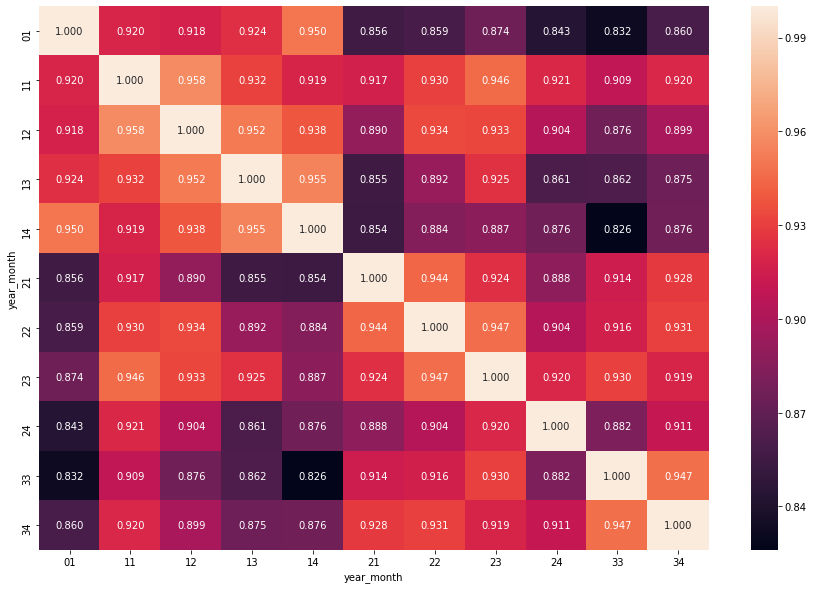

In [0]:
ee = train.groupby(['year','quarter','month','store_id']).sum()[['amount']].reset_index()
ee['year'] = np.where(ee['month']==12, ee['year']-1, ee['year'])
ee['year_month'] = ee['year'].astype('str') + ee['quarter'].astype('str') 
ee = ee.groupby(['year_month','store_id']).sum()[['amount']].reset_index()
ee_rr = ee.pivot(index='store_id', columns='year_month', values='amount')
plt.figure(figsize=(15,10))
sns.heatmap(ee_rr.corr(), annot=True, fmt='.3f')

# 예측

In [0]:
#train3 = train3.drop('index',axis=1)
#train3.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv', index=False)
train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_complited.csv')
#train3 = train3.rename(columns={'amount_lag_1':'next_amt'})

In [0]:
input_var = list(set(train3.columns) - set(['store_id','next_amt','year','region', 'open_0',
                                            'is_point','open_5','open_time_2','is_point_lag_3',
                                            'open_time_1']))
target = 'next_amt'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3','quarter']
log_col = []
for col in input_var:
  try:
    if train3[col].mean() > 100000:
      log_col.append(col)
  except:
    pass

In [0]:
X_test = train3[train3['year_quarter']==10][input_var]
X_test_id = train3[train3['year_quarter']==10][['store_id']]
X = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0)][input_var]
for col in log_col:
       X[col] = np.log(X[col]+1)
       X_test[col] = np.log(X_test[col]+1)
#X = X.fillna(-9)
#y = train3[(train3.amount_lag_1_x.isna()==False) & (train3.amount_lag_1_x>0)][target]
y = np.log(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0)][target]+1)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
X.shape, y.shape

((17511, 169), (17511,))

In [0]:
 for i in enumerate (cat_col) : 
      ca = i[1] 
      X[ca] = X[ca].astype('category') 
      X_test[ca] = X_test[ca].astype('category') 

# 베이지안

In [0]:
!pip install Bayesian-Optimization

  Created wheel for Bayesian-Optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=cae8b6cc636a325521be691510f6939b30e076bae0013dfda60eaab9b9d4e436
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built Bayesian-Optimization


In [0]:
from bayes_opt import BayesianOptimization
from time import time
import datetime
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    lambda_l1,
    lambda_l2,
    learning_rate,
    bagging_freq
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    bagging_freq = int(bagging_freq)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    assert type(bagging_freq) == int

    param = {
              'num_leaves': int(round(num_leaves)), 
              'min_data_in_leaf': int(round(min_data_in_leaf)),
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': int(round(max_depth)),
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'bagging_freq ':int(round(bagging_freq)),
              'use_missing': True,
             'use_gpu':True,
              'n_estimators': 100000,
              'objective': 'regression_l1',
              'save_binary': True,
              'seed': 42,
              'feature_fraction_seed': 42,
              'bagging_seed': 42,
              'drop_seed': 42,
              'data_random_seed': 42,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'boost_from_average': True,
              'metric':'mae'}  
    '''cv_results = list()
    n_splits = 5
    folds = KFold(n_splits=n_splits)
    training_start_time = time()

    for fold, (trn_idx, test_idx) in enumerate(folds.split(X_valid, y_valid)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))
        # valid를 kfold 내에서 검증용과 훈련용으로 나눔
        X1_valid, X2_valid = X_valid.iloc[trn_idx], X_valid.iloc[test_idx]
        y1_valid, y2_valid = y_valid.iloc[trn_idx], y_valid.iloc[test_idx]
        # X1_valid는 훈련용으로 다시 합침
        X2_train = pd.concat([X_train, X1_valid], axis=0)
        y2_train = pd.concat([y_train, y1_valid], axis=0)

        for i in enumerate (cat_col) : 
          ca = i[1] 
          X2_train[ca] = X2_train[ca].astype('category')            
       
        trn_data = lgb.Dataset(X2_train, label=y2_train)
        val_data = lgb.Dataset(X2_valid, label=y2_valid)'''
    training_start_time = time()
    start_time = time()
    cv_result = lgb.train(param, trn_data, 100000, valid_sets=[trn_data, val_data],
                          early_stopping_rounds=500,
                            verbose_eval=5000,
                            categorical_feature = cat_col)
       # cv_results.append(cv_result.best_score['valid_1']['l1'])
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    #cv_result = lgb.train(param, trn_data, folds=folds_generator, seed= 42, stratified=False, verbose_eval =1000, metrics=['mae'],
    #                   early_stopping_rounds=1000)
    return (cv_result.best_score['valid_1']['l1'])*(-1)

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (10, 174*3), # 크면 오버핏
    'min_data_in_leaf': (20, 600), # 작으면 오버핏
    'bagging_fraction' : (0.0001, 0.6),
    'feature_fraction' : (0.0001, 0.3),
    'min_child_weight': (0.0001, 0.01), # 크면 오버핏
    #'min_split_gain': (0.001, 0.1),
    'lambda_l1': (0.00001, 10), 
    'lambda_l2': (0.00001, 10),
    'max_depth':(5,174*2),
    'learning_rate': (0.008,0.0001),
    'bagging_freq': (1,10)
   # 'n_estimator' : (10000.20000),

}

In [0]:
import warnings
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

# Define train, valid
X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][input_var]
y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                    (train3.year_quarter<9)][target])
#y_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                    (train3.year_quarter<9)][target]
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                    (train3.year_quarter==9)][input_var]
y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                    (train3.year_quarter==9)][target])
#y_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                    (train3.year_quarter==9)][target]                 
# 로그변환
for col in log_col:
      X_train[col] = np.log1p(X_train[col])
      X_valid[col] = np.log1p(X_test[col])
# 범주형을 category로 타입변경
for i in enumerate (cat_col) : 
    ca = i[1] 
    X_train[ca] = X_train[ca].astype('category') 
    X_valid[ca] = X_valid[ca].astype('category') 

trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid)

#train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)

init_points = 10
n_iter = 100

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[319]	training's l1: 0.305921	valid_1's l1: 0.540202
Total training time is 0:00:04.698571
|  1        | -0.5402   |  0.2248   |  9.556    |  0.2196   |  5.987    |  1.56     |  0.006768 |  24.92    |  0.008675 |  368.6    |  372.5    |
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[270]	training's l1: 0.322466	valid_1's l1: 0.540988
Total training time is 0:00:05.411490
|  2        | -0.541    |  0.01245  |  9.729    |  0.

In [0]:
LGB_BO.max['params'], LGB_BO.max['target']

({'bagging_fraction': 0.23264255867197567,
  'bagging_freq': 1.3956937918181769,
  'feature_fraction': 0.04043143081144796,
  'lambda_l1': 3.0402555038782184,
  'lambda_l2': 9.814073490534437,
  'learning_rate': 0.0001,
  'max_depth': 200.11555300964778,
  'min_child_weight': 0.004325175606643878,
  'min_data_in_leaf': 21.487446340379112,
  'num_leaves': 377.9332443247564},
 -0.3491980638196852)

In [0]:
LGB_BO.max['params'], LGB_BO.max['target']

({'bagging_fraction': 0.2592238166834052,
  'feature_fraction': 0.17480836120480533,
  'lambda_l1': 6.118532828694847,
  'lambda_l2': 1.394947211581812,
  'learning_rate': 0.007370698163183037,
  'max_depth': 21.486282948216125,
  'min_child_weight': 0.004615092843748656,
  'min_data_in_leaf': 475.4020576079479,
  'num_leaves': 112.83199781155527},
 -0.29861943058531804)

In [0]:
LGB_BO.max['params']

{'bagging_fraction': 0.3166501728700586,
 'feature_fraction': 0.45018995784462035,
 'lambda_l1': 2.546106948274094,
 'lambda_l2': 2.840349098102507,
 'learning_rate': 0.001,
 'max_depth': 43.66716242252734,
 'min_child_weight': 0.007760966491909174,
 'min_data_in_leaf': 21.42002733649495,
 'num_leaves': 298.8291651831125}

In [0]:
LGB_BO.max['target']

-0.31180454459909496

# RFE

In [0]:
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(X.columns): 
    if col in cat_col:
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values)+ list(X_test[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [0]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
# 21.486282948216125
params = {'bagging_fraction': 0.2592238166834052,
  'feature_fraction': 0.17480836120480533,
  'lambda_l1': 6.118532828694847,
  'lambda_l2': 1.394947211581812,
  'learning_rate': 0.007370698163183037,
  'max_depth': -1,
  'min_child_weight': 0.004615092843748656,
  'min_data_in_leaf': 475.4020576079479,
  'num_leaves': 112.83199781155527,
  'n_estimators': 10000}
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
#params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['metric'] = 'mae'
params['verbose'] = -1
#params['boosting_type'] = 'gbdt'
params['random_state'] = 47

In [0]:
from sklearn.feature_selection import RFECV

clf = lgb.LGBMRegressor(**params) 
dtrain = lgb.Dataset(X, label=y)
rfe = RFECV(estimator=clf, step=1, cv=KFold(5), scoring='neg_mean_absolute_error', verbose=2)
rfe.fit(X, y)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMRegressor(bagging_fraction=0.2592238166834052,
                              boosting_type='gbdt', class_weight=None,
                              colsample_bytree=1.0,
                              feature_fraction=0.17480836120480533,
                              importance_type='split',
                              lambda_l1=6.118532828694847,
                              lambda_l2=1.394947211581812,
                              learning_rate=0.007370698163183037, max_depth=-1,
                              metric...
                              min_child_weight=0.004615092843748656,
                              min_data_in_leaf=475, min_split_gain=0.0,
                              n_estimators=10000, n_jobs=-1, num_leaves=113,
                              objective='regression_l1', random_state=47,
                              reg_alpha=0.0, reg_lambda=0.0, silent=True,
                     

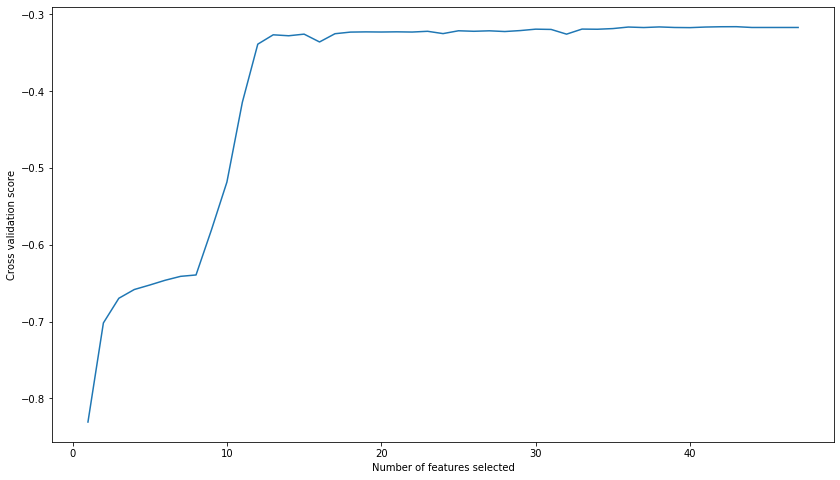

In [0]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [0]:
X.columns[rfe.ranking_ != 1]

Index(['open_time_2', 'is_point', 'open_5', 'open_0'], dtype='object')

#예측

In [0]:
!pip install shap

In [0]:
#train3.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_complited.csv', index=False)

In [0]:
from time import time
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645,
  'use_missing':True
  }
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


CV= []
iteration=[]
evals_result = {}
evals_results = []
X_test_id['amount'] = 0
n_splits = 5
folds = KFold(n_splits=n_splits)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
training_start_time = time()
'''# 1. 전체 k fold
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))

    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

    model = lgb.train(params, trn_data, 200000, valid_sets=[trn_data, val_data],
                      early_stopping_rounds=500,
                        verbose_eval=1000,
                        categorical_feature = cat_col)


    feature_importances['fold_{}'.format(fold + 1)] = model.feature_importance(importance_type='gain')
    CV.append(model.best_score['valid_1']['l1'])'''
## 2. 1분기 데이터를 valid로 사용
X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][input_var]
y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][target])
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var]
y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target])

for col in log_col:
       X_train[col] = np.log1p(X_train[col])
       X_valid[col] = np.log(X_test[col])
# 범주형을 category로 타입변경
for i in enumerate (cat_col) : 
    ca = i[1] 
    X_train[ca] = X_train[ca].astype('category') 
    X_valid[ca] = X_valid[ca].astype('category') 


for fold, (trn_idx, test_idx) in enumerate(folds.split(X_valid, y_valid)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    # valid를 kfold 내에서 검증용과 훈련용으로 나눔
    X1_valid, X2_valid = X_valid.iloc[trn_idx], X_valid.iloc[test_idx]
    y1_valid, y2_valid = y_valid.iloc[trn_idx], y_valid.iloc[test_idx]
    # X1_valid는 훈련용으로 다시 합침
    X2_train = pd.concat([X_train, X1_valid], axis=0)
    y2_train = pd.concat([y_train, y1_valid], axis=0)

    for i in enumerate (cat_col) : 
      ca = i[1] 
      X2_train[ca] = X2_train[ca].astype('category') 

    trn_data = lgb.Dataset(X2_train, label=y2_train)
    val_data = lgb.Dataset(X2_valid, label=y2_valid)

    model = lgb.train(params, trn_data, 200000, valid_sets=[trn_data, val_data],
                      early_stopping_rounds=500,
                        verbose_eval=1000,
                        categorical_feature = cat_col)
    
    explainer = shap.TreeExplainer(model)
    # Calculate Shap values
    shap_values = explainer.shap_values(X_valid)

    feature_importances['fold_{}'.format(fold + 1)] = shap_values
    CV.append(model.best_score['valid_1']['l1'])
# Predict
    X_test_id['amount'] += model.predict(X_test)
X_test_id['amount'] = np.exp(X_test_id['amount'] / n_splits) 
#X_test_id['amount'] = (X_test_id['amount'] / n_splits) * 3

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 0.415457	valid_1's l1: 0.530895
[2000]	training's l1: 0.287312	valid_1's l1: 0.40965
[3000]	training's l1: 0.237159	valid_1's l1: 0.356756
[4000]	training's l1: 0.211616	valid_1's l1: 0.332078
[5000]	training's l1: 0.195293	valid_1's l1: 0.317912
[6000]	training's l1: 0.18346	valid_1's l1: 0.309056
[7000]	training's l1: 0.174289	valid_1's l1: 0.303107
[8000]	training's l1: 0.166914	valid_1's l1: 0.297628
[9000]	training's l1: 0.16099	valid_1's l1: 0.293978
[10000]	training's l1: 0.156126	valid_1's l1: 0.291952
[11000]	training's l1: 0.152157	valid_1's l1: 0.290597
[12000]	training's l1: 0.148104	valid_1's l1: 0.289487
[13000]	training's l1: 0.144532	valid_1's l1: 0.286276
[14000]	training's l1: 0.141292	valid_1's l1: 0.283902
[15000]	training's l1: 0.138114	valid_1's l1: 0.282927
[16000]	training's l1: 0.135042	valid_1's l1: 0.282509
[17000]	training's l1: 0.133078	valid_1's l1: 0.28

In [0]:
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))

CV mean 0.26176340228669104, CV std 0.010199113509362921


In [0]:
# use_missing 사용 여부에 따른 결과 비교
# 사용 안함(fillna(-9)) : CV mean 0.29676716106456136, CV std 0.01603049718047368
# 사용 CV mean 0.2943111516105329, CV std 0.014703042943764788
# = 사용해야 함

# 3개월 full + main h + valid2
#CV mean 0.26176340228669104, CV std 0.010199113509362921
# 3개월 full + main h + valid all
# CV mean 0.25945296258264083, CV std 0.013237627446158771


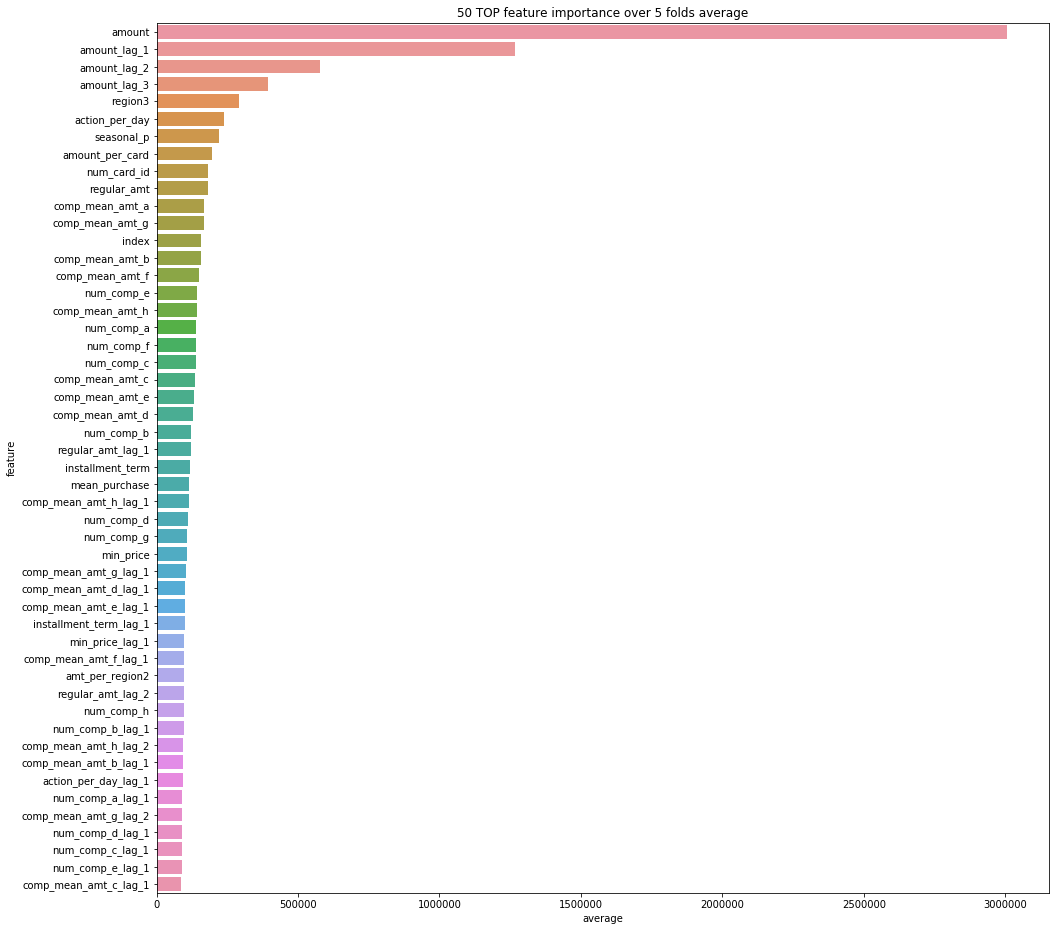

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/funda_train_prep.csv')

In [0]:
rest_store = list(set(train.store_id.unique()) - set(train[((train['year']==2019) & (train['month']<=2)) | ((train['year']==2018) & (train['month']==12))].store_id.unique())) # 19년 1분기 매출이 없는 가게
rest_2018_1 = train3.loc[(train3['store_id'].isin(rest_store)) & (train3['quarter']==2) & (train3['year']==2018)][['store_id','amount']] # 18년 2분기로 대체
rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train3.loc[(train3['store_id'].isin(rest_list1)) & (train3['quarter']==2) & (train3['year']==2017)][['store_id','amount']] # 17년 2분기로 대체
reset_st = pd.concat([rest_2018_1, rest_2018_2], axis=0)

In [0]:
X_test_id = pd.concat([X_test_id, reset_st], axis=0)

In [0]:
submission2 = pd.merge(submission.drop('amount',axis=1),X_test_id, on='store_id')

# 결과

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h']
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.003412718062449079,
 'feature_fraction': 0.489295310930055,
 'lambda_l1': 3.5342896506646473,
 'lambda_l2': 2.1870242140512817,
 'learning_rate': 0.003058566879826488,
 'max_depth': 5.740446517340904,
 'min_child_weight': 0.003648810712588299,
 'min_data_in_leaf': 2905.541708337954,
 'num_leaves': 8.904827407004749}
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 10000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 1,103,566.56700
'''



submission.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1218.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 4 lag
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.2592238166834052,
  'feature_fraction': 0.17480836120480533,
  'lambda_l1': 6.118532828694847,
  'lambda_l2': 1.394947211581812,
  'learning_rate': 0.007370698163183037,
  'max_depth': 21.486282948216125,
  'min_child_weight': 0.004615092843748656,
  'min_data_in_leaf': 475.4020576079479,
  'num_leaves': 112.83199781155527}
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 1,103,566.56700
'''



#submission.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1218_4lag.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 3 lag, 5fold shuffle
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645}
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 880,924
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1219_3lag_s.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 3 lag, 5fold qaurter=1 shuffle
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645}
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 877292.680150
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1219_3lag_quarter1.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 3 lag, 
       
5fold qaurter=1 shuffle= False, use_missing, 19-1분기 없는 가게 값 대체 

target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645}
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 872,716.34194
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1220_3lag_quarter1.csv',index=False)

**3개월 모두 amount 있는 분기만 사용**

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] 
       + 3 lag + business_amt,count + main_h + 3개월 꽉 안 찬 분기 제거 + index 있었음...
       
5fold qaurter=1 shuffle= False, use_missing, 19-1분기 없는 가게 값 대체 

target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645,
  'use_missing':True
  }
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 880520.600180
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1221_3lag_full_quarter1.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] 
       + 3 lag + business_amt,count + main_h + 3개월 꽉 안 찬 분기 제거 + 모든 데이터 검증셋 + index 있었음...
       
5fold qaurter=1 shuffle= False, use_missing, 19-1분기 없는 가게 값 대체 

target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645,
  'use_missing':True
  }
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 892418.507010
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1221_3lag_full_quarter1_allvalid.csv',index=False)

In [0]:
'''
input_var = ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] 
       + 3 lag + business_amt,count + main_h + 3개월 꽉 안 찬 분기 제거 + 9분기 데이터 검증셋 + 매출시간 비율 추가
       
5fold qaurter=1 shuffle= False, use_missing, 19-1분기 없는 가게 값 대체 

target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645,
  'use_missing':True
  }
params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

score = 855,159.61695
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1221_3lag_full_quarter1_9valid.csv',index=False)

# 결론(알아낸 것들)

- use missing 사용하는 게 좋다
- 3개월 꽉 안찬 분기를 뺏더니 성능이 만점정도 떨어진다
- 전체 valid보다 quarter=1만 valid하는 게 더 좋다
- validation set은 3~5월보다 예측 직전 분기로 하는 것이 낫다.